**Importing** **Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # for Standardization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # for classification
from sklearn.model_selection import GridSearchCV
from sklearn import svm

**Loading Dataset CIFAR10**

In [2]:
cifar10 = tf.keras.datasets.cifar10
(X, y), (X_test, y_test) = cifar10.load_data() # load cifar10

**Split Data Process**

Επειδή ο διαχωρισμός των δεδομένων σε train-test γίνεται αυτόματα σε 90%-10% χρησιμοποιώ την μέθοδο concatenate(), ώστε να ενοποιήσω τα σύνολα εκπαίδευσης - δοκιμής και στη συνέχεια τα ξαναχωρίζω σε train-validation-test με ποσοστά 60%-20%-20%.

**Επιλέγω τυχαία ένα υποσύνολο του συνολικού dataset cifar10.

In [3]:
# combine train and test dataset
X_full = np.concatenate((X, X_test), axis=0)
y_full = np.concatenate((y, y_test), axis=0)

# select a random subset
subset_size = 10000
indices = np.random.choice(len(X_full), size=subset_size, replace=False)
X_full = X_full[indices]
y_full = y_full[indices]

# Split data into train-validation-test sets (60%-20%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4,
                                                    random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=0)

**Data** **Preprocessing**

Εαν εμφανίσουμε το σχήμα των δεδομένων εκπαίδευσης - δοκιμής με την μέθοδο
shape() βλέπουμε τις 4 διαστάσεις του πίνακα που περιέχει τις εικόνες.

1. Για τα δεδομένα-εικόνες: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων, η δεύτερη και η τρίτη το ύψος και το πλάτος των εικόνων σε pixel και η τέταρτη τον αριθμό των καναλιών χρώματος (RGB).

2. Για τα δεδομένα-labels: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων και η δεύτερη ότι για κάθε εικόνα αντιστοιχεί ένα label δηλαδή μία κατηγορία που αναπαριστά κάθε εικόνα.

In [4]:
print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 32, 32, 3)
y_train.shape: (6000, 1)
X_test.shape: (2000, 32, 32, 3)
y_test.shape: (2000, 1)
X_val.shape: (2000, 32, 32, 3)
y_val.shape: (2000, 1)


Ο SVM δεν μπορεί να επεξεργαστεί δεδομένα εικόνας απευθείας σε μορφή πίνακα 2D ή 3D. Επομένως, για να μπορέσει να δεχθεί τις εικόνες ως δεδομένα εισόδου και να ακολουθήσει η διαδικασία εκπαίδευσης - δοκιμής θα πρέπει πρώτα να γίνει μετατροπή (reshape()) των δεδομένων σε μονοδιάστατα διανύσματα (flat vectors).


In [5]:
# Reshaping Data into vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 3072)
y_train.shape: (6000, 1)
X_test.shape: (2000, 3072)
y_test.shape: (2000, 1)
X_val.shape: (2000, 3072)
y_val.shape: (2000, 1)


Για τη βελτίωση της απόδοσης του SVM είναι απαραίτητες η "Κανονικοποίηση" των δεδομένων και η "Μέθοδος Ανάλυσης Κύριων Συνιστωσών" (PCA).

Κάνουμε κανονικοποίηση/ για να εξασφαλίσουμε ότι όλα τα χαρακτηρισιτκά έχουν την ίδια κλίμακα, έτσι ώστε να μην κυριαρχούν χαρακτηριστικά σε μεγάλες τιμές στην pca.

Πριν κάνω pca βλέπω πόσες συνιστώσες μπορώ κρατήσω ώστε να κρατήσω όσο το δυνατόν περισσότερη πληροφορία.

Text(0, 0.5, 'cumulative explained variance')

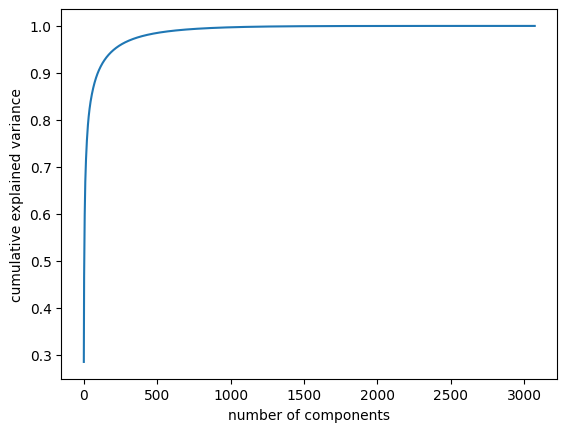

In [6]:
combined=np.vstack((X_train, X_val))

pca = PCA().fit(combined)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
print(pca.explained_variance_ratio_.cumsum()[50])
print(pca.explained_variance_ratio_.cumsum()[100])
print(pca.explained_variance_ratio_.cumsum()[150])
print(pca.explained_variance_ratio_.cumsum()[500])

0.8462758647254911
0.9036987760259488
0.9313912884995265
0.9851292902470361


In [8]:
# Standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [9]:
# Normalization
# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_val = X_val / 255.0

Με το PCA επιτυγχάνεται η μείωση διάστασης των δεδομένων κρατώντας τις πιο σημαντικές συνιστώσες δηλαδή επιτυγχάνεται η αναδόμηση των δεδομένων σε νέες διαστάσεις, δίνοντας ίση βαρύτητα σε όλα τα χαρακτηριστικά εφόσον έχουν προηγηθεί είτε Normalization είτε Standardization.

In [10]:
# pca for dimensionality reduction
pca_cifar = PCA(n_components=100)
X_train = pca_cifar.fit_transform(X_train)
X_test = pca_cifar.transform(X_test)
X_val = pca_cifar.transform(X_val)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 100)
y_train.shape: (6000, 1)
X_test.shape: (2000, 100)
y_test.shape: (2000, 1)
X_val.shape: (2000, 100)
y_val.shape: (2000, 1)


**Model** **Training**

Types of Kernel: Linear, RBF, Polynomial

SVM Linear Kernel

Δοκιμάζω διαφορετικές τιμές της παραμέτρου C (regularization parameter).
Δημιουργία μεθόδου linear_model_method (), η οποία θα παίρνει ως όρισμα διαφορετικές παραμέτρους C από μία λίστα που θα δημιουργήσω.

In [11]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

# Function to train SVM with Linear Kernel
def linear_model_SVM (c):
    start_time = time.time()
    svm_classifier = SVC(kernel='linear', C=c)

    svm_classifier.fit(X_train, y_train.ravel())

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_caccuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel())
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
            'Kernel': 'linear',
            'C': c,
            'Train Accuracy': acc_train,
            'Validation Accuracy': acc_val,
            'Test Accuracy': acc_test,
            'Run time: ': run_time
            })

Train Accuracy for C = 0.0001: 0.4028333333333333
Validation Accuracy for C = 0.0001: 0.3965
Test Accuracy for C = 0.0001: 0.383
Train Accuracy for C = 0.0005: 0.43683333333333335
Validation Accuracy for C = 0.0005: 0.3995
Test Accuracy for C = 0.0005: 0.3785
Train Accuracy for C = 0.001: 0.4513333333333333
Validation Accuracy for C = 0.001: 0.4
Test Accuracy for C = 0.001: 0.3815
Train Accuracy for C = 0.005: 0.4618333333333333
Validation Accuracy for C = 0.005: 0.393
Test Accuracy for C = 0.005: 0.3745
Train Accuracy for C = 0.01: 0.4638333333333333
Validation Accuracy for C = 0.01: 0.3915
Test Accuracy for C = 0.01: 0.3815
Train Accuracy for C = 0.05: 0.4625
Validation Accuracy for C = 0.05: 0.382
Test Accuracy for C = 0.05: 0.375
Train Accuracy for C = 0.1: 0.4625
Validation Accuracy for C = 0.1: 0.386
Test Accuracy for C = 0.1: 0.372


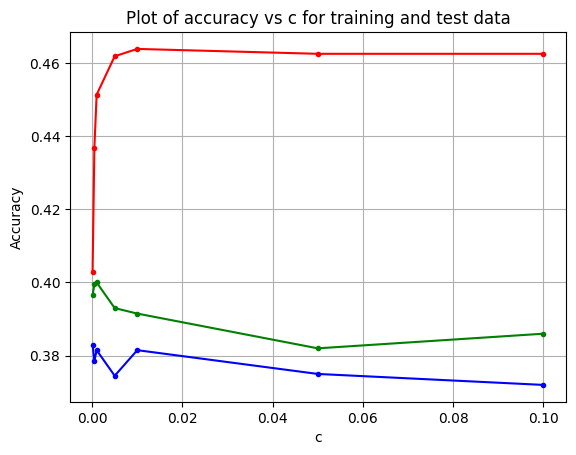

In [12]:
# Run SVM model for different C values
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for c in C_values:
  linear_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training and test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [13]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,linear,0.0001,0.402833,0.3965,0.3830,1.703533
1,linear,0.0005,0.436833,0.3995,0.3785,1.663608
2,linear,0.0010,0.451333,0.4000,0.3815,1.712562
3,linear,0.0050,0.461833,0.3930,0.3745,2.549236
4,linear,0.0100,0.463833,0.3915,0.3815,3.930022
5,linear,0.0500,0.462500,0.3820,0.3750,16.715113
6,linear,0.1000,0.462500,0.3860,0.3720,34.737740


Παρατήρησεις:

Για μικρό dataset σε σχέση με τα συνολικά δεδομένα παρατήρησα ότι το train set αυξάνεται καθώς αυξάνεται και η τιμή του C (παράγοντας κανονικοποίησης). Αυτό υποδηλώνει ότι το μοντέλο κάνει overfitting, δηλαδή υπερπροσαρμόζεται στα δεδομένα εκπαίδευσης, αλλά αδυνατεί να γενικεύσει με επιτυχία σε νέα δεδομένα. Αυτό φαίνεται στις τιμές των validation και test accuracies, οι οποίες είναι χαμηλές.

SVM RBF Kernel

In [14]:
# Function to train SVM with RBF Kernel
def rbf_model_SVM (C, g):

    start_time = time.time()

    svm_classifier = SVC(kernel='rbf', C=c, gamma=g)

    svm_classifier.fit(X_train, y_train)

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_accuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel)
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
              'Kernel': 'RBF',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test,
               'Run time: ': run_time
                  })

C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0001: 0.1055
Validation Accuracy for C = 0.0001: 0.0925
Test Accuracy for C = 0.0001: 0.0


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0005: 0.1055
Validation Accuracy for C = 0.0005: 0.0925


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy for C = 0.0005: 0.0
Train Accuracy for C = 0.001: 0.1055
Validation Accuracy for C = 0.001: 0.0925
Test Accuracy for C = 0.001: 0.0


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.005: 0.1055
Validation Accuracy for C = 0.005: 0.0925
Test Accuracy for C = 0.005: 0.0


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.01: 0.1055
Validation Accuracy for C = 0.01: 0.0925
Test Accuracy for C = 0.01: 0.0


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.05: 0.1055
Validation Accuracy for C = 0.05: 0.0925
Test Accuracy for C = 0.05: 0.0


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.1: 0.1055
Validation Accuracy for C = 0.1: 0.0925
Test Accuracy for C = 0.1: 0.0


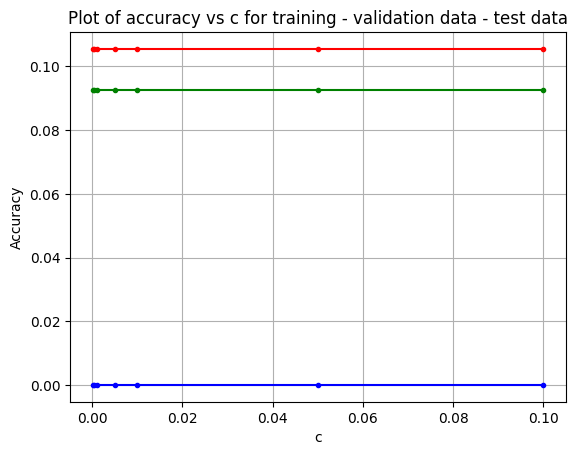

In [15]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_accuracy = []
test_set_accuracy = []
results = []

for c in C_values:
  rbf_model_SVM(c, 'auto')

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_accuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [16]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,RBF,0.0001,0.1055,0.0925,0.0,4.926456
1,RBF,0.0005,0.1055,0.0925,0.0,4.930887
2,RBF,0.0010,0.1055,0.0925,0.0,4.885711
3,RBF,0.0050,0.1055,0.0925,0.0,4.917331
4,RBF,0.0100,0.1055,0.0925,0.0,4.994480
5,RBF,0.0500,0.1055,0.0925,0.0,5.049546
6,RBF,0.1000,0.1055,0.0925,0.0,5.057281


Polynomial Kernel

In [17]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

def poly_model_SVM (C):
      start_time = time.time()
      svm_classifier = SVC(probability= False, kernel='poly', C=c)

      svm_classifier.fit(X_train, y_train)

      # Accuracy for train set
      pred = svm_classifier.predict(X_train)
      acc_train = np.mean(pred == y_train.ravel())
      train_set_accuracy.append(acc_train)
      print("Train Accuracy for C = {}: {}".format(c, acc_train))

      # Accuracy for validation set
      pred = svm_classifier.predict(X_val)
      acc_val = np.mean(pred == y_val.ravel())
      val_set_caccuracy.append(acc_val)
      print("Validation Accuracy for C = {}: {}".format(c, acc_val))

      # Accuracy for test set
      pred = svm_classifier.predict(X_test)
      acc_test = np.mean(pred == y_test.ravel())
      test_set_accuracy.append(acc_test)
      print("Test Accuracy for C = {}: {}".format(c, acc_test))

      # Run time
      end_time = time.time()
      run_time = end_time - start_time

      results.append({
              'Kernel': 'Polynomial',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test
                  })

C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0001: 0.1055
Validation Accuracy for C = 0.0001: 0.0925
Test Accuracy for C = 0.0001: 0.116


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0005: 0.10616666666666667
Validation Accuracy for C = 0.0005: 0.093
Test Accuracy for C = 0.0005: 0.116


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.001: 0.10816666666666666
Validation Accuracy for C = 0.001: 0.0955
Test Accuracy for C = 0.001: 0.1175


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.005: 0.12966666666666668
Validation Accuracy for C = 0.005: 0.1115
Test Accuracy for C = 0.005: 0.1315


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.01: 0.161
Validation Accuracy for C = 0.01: 0.1425
Test Accuracy for C = 0.01: 0.1605


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.05: 0.2673333333333333
Validation Accuracy for C = 0.05: 0.2115
Test Accuracy for C = 0.05: 0.229


C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.1: 0.35
Validation Accuracy for C = 0.1: 0.271
Test Accuracy for C = 0.1: 0.274


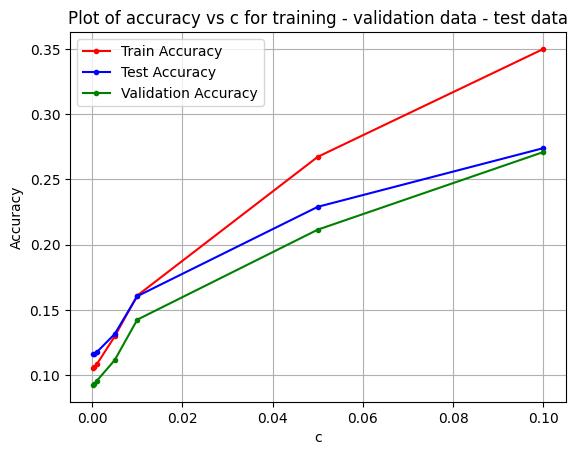

In [18]:
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []
for c in C_values:
  poly_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Validation Accuracy'])
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [19]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy
0,Polynomial,0.0001,0.105500,0.0925,0.1160
1,Polynomial,0.0005,0.106167,0.0930,0.1160
2,Polynomial,0.0010,0.108167,0.0955,0.1175
3,Polynomial,0.0050,0.129667,0.1115,0.1315
4,Polynomial,0.0100,0.161000,0.1425,0.1605
5,Polynomial,0.0500,0.267333,0.2115,0.2290
6,Polynomial,0.1000,0.350000,0.2710,0.2740


Classifier 2: Grid Search - Cross Validation

In [20]:
# defining parameter range
param_grid = {'C': C_values,
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'rbf', 'poly']}
# svm classifier
svm_classifier2 = SVC()

# grid search
grid_search = GridSearchCV(svm_classifier2, param_grid, cv=5, n_jobs=-1)  # cv=5 για 5-fold cross-validation

# train grid_search
grid_search.fit(X_train, y_train)

# find best parameters of grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'C': 0.0005, 'gamma': 'scale', 'kernel': 'linear'}


In [21]:
acc = grid_search.best_score_
print("Best Accuracy:", acc)

Best Accuracy: 0.37266666666666665
